<a href="https://colab.research.google.com/github/Raytr0/Toilet-Accessibility-Detection/blob/main/Crepancy_Item_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ultralytics
from ultralytics import YOLO
!pip install roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.2 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 70.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 103.6 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12

In [ ]:
# Download dataset A
from roboflow import Roboflow
rf = Roboflow(api_key="BJDNkOnpT2z6XuaFpI94")
project = rf.workspace("adrian-gorcea").project("bathroom-sdsne")
version = project.version(2)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to bathroom-2 in yolov8:: 100%|██████████| 1560/1560 [00:00<00:00, 4639.30it/s]


In [ ]:
# Download dataset B
from roboflow import Roboflow
rf = Roboflow(api_key="BJDNkOnpT2z6XuaFpI94")
project = rf.workspace("image-bounding-for-datasets").project("accessible-toilets")
version = project.version(1)
datasetA = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Accessible-Toilets-1 in yolov8:: 100%|██████████| 1385/1385 [00:00<00:00, 9251.05it/s]


In [ ]:
import os, yaml, shutil
from ultralytics import YOLO

# Unified class list
unified_classes = [
    "toilet",          # 0
    "grab_handle",     # 1
    "mirror",          # 2
    "sink",            # 3
    "soap",            # 4
    "towel",           # 5
    "wheelchair_logo"  # 6
]


# Load original class order for Dataset 1
with open("/content/Accessible-Toilets-1/data.yaml", "r") as f:
    d1 = yaml.safe_load(f)
orig1 = d1["names"]
print("Dataset 1 original classes:", orig1)

# Correct mapping old → new
dataset1_id_map = {
    0: 1,   # grab_handle → newID 1
    1: 0,   # toilet → newID 0
    2: 6    # wheelchair_logo → newID 6
}
print("Dataset 1 ID map:", dataset1_id_map)

# Load original class order for Dataset 2
with open("/content/bathroom-2/data.yaml", "r") as f:
    d2 = yaml.safe_load(f)
orig2 = d2["names"]
print("Dataset 2 original classes:", orig2)

# Build mapping for dataset 2
dataset2_id_map = {}
dataset2_name_to_new = {
    "mirror": 2,
    "sink": 3,
    "soap": 4,
    "towel": 5,
    "wc": 0,
    "towel-sink-soap-mirror-wc": None
}

for old_id, name in enumerate(orig2):
    dataset2_id_map[old_id] = dataset2_name_to_new[name]

print("Dataset 2 ID map:", dataset2_id_map)

Dataset 1 original classes: ['grab_handle', 'toilet', 'wheelchair_logo']
Dataset 1 ID map: {0: 1, 1: 0, 2: 6}
Dataset 2 original classes: ['mirror', 'sink', 'soap', 'towel', 'towel-sink-soap-mirror-wc', 'wc']
Dataset 2 ID map: {0: 2, 1: 3, 2: 4, 3: 5, 4: None, 5: 0}


In [ ]:
# Rewriter function
def rewrite_labels(label_folder, id_map):
    if not os.path.exists(label_folder):
        print("Skipping missing folder:", label_folder)
        return

    for file in os.listdir(label_folder):
        if not file.endswith(".txt"):
            continue

        path = os.path.join(label_folder, file)
        new_lines = []

        with open(path, "r") as f:
            for line in f:
                parts = line.strip().split()
                old_id = int(parts[0])

                if old_id not in id_map:
                    print("Skipping bad ID", old_id, "in", path)
                    continue

                new_id = id_map[old_id]
                if new_id is None:
                    continue

                new_lines.append(" ".join([str(new_id)] + parts[1:]))

        with open(path, "w") as f:
            f.write("\n".join(new_lines))

        print("Rewritten:", path)

In [ ]:
# Apply rewrite to datasets
# Dataset 1
for folder in [
    "/content/Accessible-Toilets-1/train/labels",
    "/content/Accessible-Toilets-1/test/labels"
]:
    rewrite_labels(folder, dataset1_id_map)

# Dataset 2
for folder in [
    "/content/bathroom-2/train/labels",
    "/content/bathroom-2/valid/labels",
    "/content/bathroom-2/test/labels"
]:
    rewrite_labels(folder, dataset2_id_map)

# Create merged dataset folders
!mkdir -p /content/combined/images/train
!mkdir -p /content/combined/images/valid
!mkdir -p /content/combined/images/test

!mkdir -p /content/combined/labels/train
!mkdir -p /content/combined/labels/valid
!mkdir -p /content/combined/labels/test

# Copy function
def copy_split(src, split):
    img_s = f"{src}/{split}/images"
    lbl_s = f"{src}/{split}/labels"
    img_d = f"/content/combined/images/{split}"
    lbl_d = f"/content/combined/labels/{split}"

    if os.path.exists(img_s):
        shutil.copytree(img_s, img_d, dirs_exist_ok=True)
    if os.path.exists(lbl_s):
        shutil.copytree(lbl_s, lbl_d, dirs_exist_ok=True)

# Copy from dataset 1
copy_split("/content/Accessible-Toilets-1", "train")
copy_split("/content/Accessible-Toilets-1", "test")

# Copy from dataset 2
copy_split("/content/bathroom-2", "train")
copy_split("/content/bathroom-2", "valid")
copy_split("/content/bathroom-2", "test")


# Build combined.yaml
combined = {
    "train": "/content/combined/images/train",
    "val": "/content/combined/images/valid",
    "test": "/content/combined/images/test",
    "names": unified_classes,
    "nc": len(unified_classes)
}

with open("/content/combined.yaml", "w") as f:
    yaml.dump(combined, f)

print("combined.yaml created!")

Rewritten: /content/Accessible-Toilets-1/train/labels/000308_jpg.rf.b13162f0e690304db94b1cbc0a262c89.txt
Rewritten: /content/Accessible-Toilets-1/train/labels/000110_jpg.rf.0dfe98edc42971f55e9591acd12ea315.txt
Rewritten: /content/Accessible-Toilets-1/train/labels/000102_jpg.rf.834d1fba88de5fc79d7500e78a5491d0.txt
Rewritten: /content/Accessible-Toilets-1/train/labels/000255_png.rf.3ec55fe784e44f2b31e3a462c0c2604d.txt
Rewritten: /content/Accessible-Toilets-1/train/labels/000138_jpg.rf.d466545b2e191752bcd265f73856aba5.txt
Rewritten: /content/Accessible-Toilets-1/train/labels/000168_jpg.rf.28d814f96a1a1040dc2b7d14d59c9728.txt
Rewritten: /content/Accessible-Toilets-1/train/labels/000340_png.rf.583a4184fc9702a151dc9788a20d883b.txt
Rewritten: /content/Accessible-Toilets-1/train/labels/000102_jpg.rf.1bb13fe013f803d9339c0365348fd2b8.txt
Rewritten: /content/Accessible-Toilets-1/train/labels/000196_jpg.rf.532f2eed77f9738b415d211d457a346f.txt
Rewritten: /content/Accessible-Toilets-1/train/labels/0

In [ ]:
# TRAIN YOLOv8 ON MERGED DATASET
model = YOLO("yolov8n.pt")

model.train(
    data="/content/combined.yaml",
    epochs=100,
    imgsz=640,
    batch=16
)

Ultralytics 8.3.228 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/combined.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train3, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0,

In [ ]:
# Load trained model
model = YOLO("/content/runs/detect/train/weights/best.pt")

Saving accessible bathroom.png to accessible bathroom.png

image 1/1 /content/converted.jpg: 416x640 4 toilets, 1 grab_handle, 38.7ms
Speed: 2.9ms preprocess, 38.7ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)
Results saved to /content/runs/detect/predict


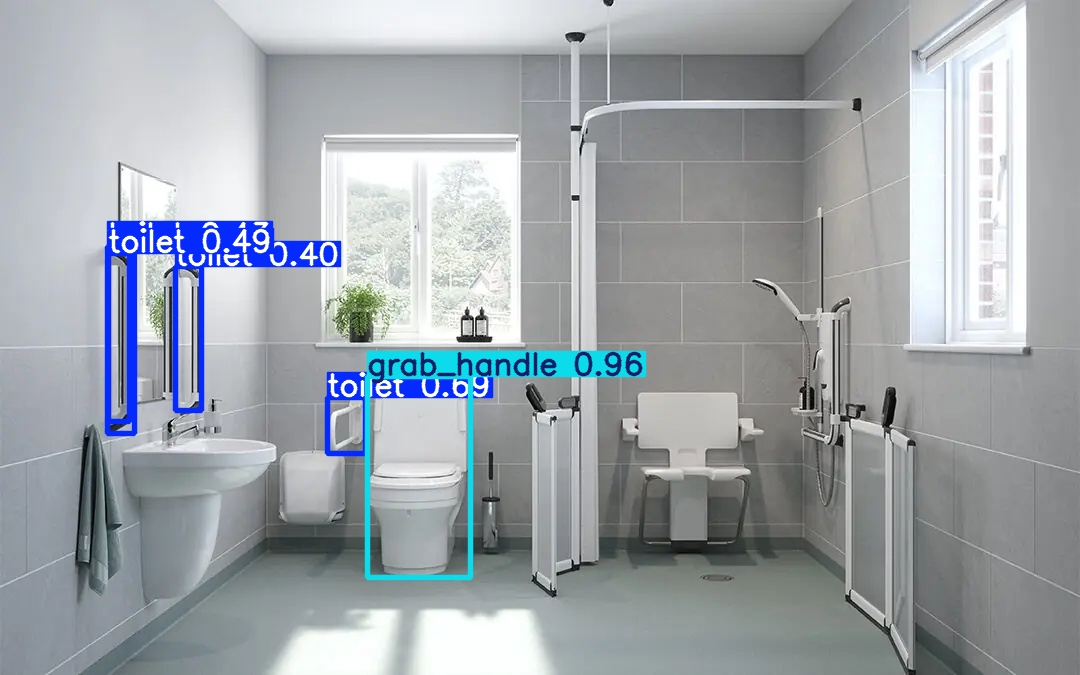

In [ ]:
from google.colab import files
uploaded = files.upload()   # Upload PNG

# Get the actual filename uploaded
filename = list(uploaded.keys())[0]

import cv2

# Read uploaded image using its real filename
img = cv2.imread(filename)

# Convert PNG -> JPG
cv2.imwrite("converted.jpg", img)

# Run YOLO on converted file
results = model.predict("converted.jpg", save=True)

# Show result
from IPython.display import Image, display
display(Image("/content/runs/detect/predict/converted.jpg"))
